# Explore Gulf of Mexico SSTs during the 2020 hurricane season 
### Search by user-defined geographic region of interest using shapefiles

The evolution of sea surface temperature (SST) anomalies in the Gulf of Mexico before, during, and after Tropical Cyclones can be explored using NASA remote sensing data, such as the MODIS Aqua SST dataset. An ocean response can often be seen in the wake of hurricane tracks, with cold wakes, or areas of cooler water, along or to the right of hurricane tracks in association with wind-induced water column mixing that brings cooler waters at depth to the surface. These cold signatures are generally patchy and spatially confined. This notebook walks through the discovery, exploratory analysis, and downloading of remote sensing ocean SST level 2 (L2) data over a geographic region of interest defined by the user (through the use of common GIS files such as .shp) during the 2020 hurricane season. 

As NASA Earthdata transitions to the Earthdata Cloud, it will be common for some data to exist in a traditional on-premise storage system, accessed by direct download to a local environment, while other data will have migrated to the cloud system. This need to access and customize data from the Earthdata Cloud, and work with it locally is described in this notebook. This access of cloud-based data and downloding to local environment for further analysis or use is presented in the Introduction (Part I) of the workshop, and described again here:

<img align="center"
     src="shpSearch_downloadLocal_diagram.png">

--> insert final data figure here <--

*Note: In this example we are using a shape file to search on ocean remote sensing data, although one can do this type of search on any Earthdata (DAAC) data. For example, of particular interest could be using shape files to search on terrestrial hydrology data (e.g watersheds), globally (depending on data availability of course).* 

*Note: Here we show a programmatic way of completing this type of workflow, but this can also be accomplished through the Earthdata Search user interface. For a video tutorial on how to do this, please see https://www.youtube.com/watch?v=d1BR8w3u0dI&list=PLDWiCz1Ka4kSbqkoeOcPXGAv0gp8OS1Ah&index=7, and disregard the comments about 'UAT' (test environment), as this capability has since become operational. Use https://search.earthdata.nasa.gov/ and follow the rest of the steps in the video tutorial. Search by HUC (hydrologic unit code) capability is also available, if you are working with data over the United States. A video tutorial on how to search by HUC in Earthdata Search is available here: https://www.youtube.com/watch?v=8TLJOFe7XPw&list=PLDWiCz1Ka4kSbqkoeOcPXGAv0gp8OS1Ah&index=6*

#### Learning Objectives:
0. Earthdata Login Authentication (for download access from Earthdata data archive)
1. Search CMR for collection and granule IDs, using the collection shortname and provider
2. Download a file from the PO.DAAC (Earthdata) cloud archive to local computer and preview the data
3. Search a collection by user-provided shapefile (ESRI shp) and temporal range
4. Donwload the first file (from the PO.DAAC cloud archive to local computer) and preview subset
4. Download all data (from the PO.DAAC cloud archive to local computer) based on shp and time search criteria (<-- *this still needs to be written*)

----- 

## First, import needed packages and libraries

In [16]:
from urllib import request, parse
from http.cookiejar import CookieJar
import getpass
import netrc
import os
import requests
import json
import pprint
from osgeo import gdal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import rasterio
from rasterio.plot import show
import numpy as np
import os
import time
from netCDF4 import Dataset
from owslib.wms import WebMapService
import numpy.ma as ma
import cartopy
%matplotlib inline

## Earthdata Login Authentication

An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

At this point in time (as we are still transitioning to a cloud environment), in order to access data from the Earthdata Cloud, you need special, early access, persmissions. For the workshop today, you have already been added to the list and the Earthdata login you provided prior to the workshop has been granted this access.

The `setup_earthdata_login_auth` function will allow Python scripts to log into any Earthdata Login application programmatically.  To avoid being prompted for
credentials every time you run and also allow clients such as curl to log in, you can add the following
to a `.netrc` (`_netrc` on Windows) file in your home directory:

```
machine urs.earthdata.nasa.gov
    login <your username>
    password <your password>
```

Make sure that this file is only readable by the current user or you will receive an error stating
"netrc access too permissive."

`$ chmod 0600 ~/.netrc` 

In [2]:
from netrc import netrc
from platform import system
from getpass import getpass
from urllib import request
from http.cookiejar import CookieJar
from os.path import join, expanduser

TOKEN_DATA = ("<token>"
              "<username>%s</username>"
              "<password>%s</password>"
              "<client_id>PODAAC CMR Client</client_id>"
              "<user_ip_address>%s</user_ip_address>"
              "</token>")


def setup_cmr_token_auth(endpoint: str='cmr.earthdata.nasa.gov'):
    ip = requests.get("https://ipinfo.io/ip").text.strip()
    return requests.post(
        url="https://%s/legacy-services/rest/tokens" % endpoint,
        data=TOKEN_DATA % (input("Username: "), getpass("Password: "), ip),
        headers={'Content-Type': 'application/xml', 'Accept': 'application/json'}
    ).json()['token']['id']


def setup_earthdata_login_auth(endpoint: str='urs.earthdata.nasa.gov'):
    netrc_name = "_netrc" if system()=="Windows" else ".netrc"
    try:
        username, _, password = netrc(file=join(expanduser('~'), netrc_name)).authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        print('Please provide your Earthdata Login credentials for access.')
        print('Your info will only be passed to %s and will not be exposed in Jupyter.' % (endpoint))
        username = input('Username: ')
        password = getpass('Password: ')
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)


# Get your authentication token for searching restricted records in the CMR:
_token = setup_cmr_token_auth(endpoint="cmr.earthdata.nasa.gov")

# Start authenticated session with URS to allow restricted data downloads:
setup_earthdata_login_auth(endpoint="urs.earthdata.nasa.gov")

Username:  oceancat18
Password:  ···········


-----------
### Explore data availability using the Common Metadata Repository
The Common Metadata Repository (CMR) is a robust metadata system that catalogs Earth Science data and associated service metadata records. CMR supports data search and discovery through an Application Programming Interface, or API, enabling reproducible data product and data file searches using a number of helpful variables, including geographic area, keyword, provider, and time.

General CMR API documentation: https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html

## 1. Identify a data collection of interest

Data sets are selected by data set IDs (e.g. `MODIS_A-JPL-L2P-v2019.0`). In the CMR API documentation, a data set id is referred to as a "short name". These short names are located at the top of each NSIDC data set landing page in gray above the full title: 

- go to https://search.earthdata.nasa.gov/search and type *POCLOUD* in the search box (which is the PO.DAAC data provider for cloud-based Pathfinder datasets in a restricted operational cloud environment). Click on the (i) next to the data collection of interest; the `shortname` is the subheader name below the main full data collection name.

<img align="center"
     src="EDS_info.png">


Shortname:  

 <img align="center"
     src="EDS_shortname.png">

In this tutorial we will be using the **MODIS-Aqua SST L2 collection**, with the shortname: `MODIS_A-JPL-L2P-v2019.0`. Data from our collection of interest can be obtained from the PO.DAAC (Earthdata) cloud archive.

### Search by dataset shortname and provider

To search Earthdata from this notebook, we can use the following code with key words that describe our dataset (also knows as a **collection**). This snippet of Python code uses the `requests` module to get collection metadata from the CMR, with our dataset of interset *shortname* and *provider* as search criteria (parameters). In subsequet notebooks (demos), this functionality is hidden in a package called `tutorial_helper_functions` for ease of use. For now, this code snippet will help us understand how the request is made:

In [3]:
modis_coll = requests.get(
    url="https://cmr.earthdata.nasa.gov/search/collections.umm_json",    # CMR API url
    params={'ShortName': "MODIS_A-JPL-L2P-v2019.0",      # dataset collection shortname
            'provider': "POCLOUD",      # data provider
            'token': _token},
).json()

modis_coll['items'][0]['meta']   # print collection metadata

{'revision-id': 2,
 'deleted': False,
 'format': 'application/vnd.nasa.cmr.umm+json',
 'provider-id': 'POCLOUD',
 'user-id': 'cia001',
 'has-formats': True,
 'associations': {'services': ['S1962070864-POCLOUD']},
 'has-spatial-subsetting': False,
 'native-id': 'GHRSST+Level+2P+Global+Sea+Surface+Skin+Temperature+from+the+Moderate+Resolution+Imaging+Spectroradiometer+(MODIS)+on+the+NASA+Aqua+satellite+(GDS2)',
 'has-transforms': False,
 'has-variables': False,
 'concept-id': 'C1940473819-POCLOUD',
 'revision-date': '2020-09-15T19:49:35.109Z',
 'granule-count': 0,
 'has-temporal-subsetting': False,
 'concept-type': 'collection'}

Based on the metadata retrieved above, we now know the collection ID (*concept-id*) is `C1940473819-POCLOUD`

To **retrieve the *granule (file)* metadata** from the CMR:

In [4]:
modis_gran = requests.get(
    url="https://cmr.earthdata.nasa.gov/search/granules.umm_json", 
    params={'ShortName': "MODIS_A-JPL-L2P-v2019.0", 
            'provider': "POCLOUD",
            'token': _token, },
).json()

modis_gran['items'][0]['meta']

{'concept-type': 'granule',
 'concept-id': 'G1966131201-POCLOUD',
 'revision-id': 1,
 'native-id': '20020704000015-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0',
 'provider-id': 'POCLOUD',
 'format': 'application/vnd.nasa.cmr.umm+json',
 'revision-date': '2020-11-12T11:09:16.542Z'}

In this case, the metadata tells us that the the granule ID is `G1966131201-POCLOUD`, among other information.

---------- 
### Give it a try!
Instead of MODIS, try searching for the `TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2` collection, and get a glimpse into its metadata.

----------

## 2. Download a granule & preview data

### Access & preview the data - get a quick feel for what the data looks like
Here is how to list the URLs needed to access the data:

In [5]:
modis_gran['items'][0]['umm']['RelatedUrls']

[{'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/MODIS_A-JPL-L2P-v2019.0/20020704000015-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc.md5',
  'Description': 'Download 20020704000015-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc.md5',
  'Type': 'EXTENDED METADATA'},
 {'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MODIS_A-JPL-L2P-v2019.0/20020704000015-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc',
  'Description': 'Download 20020704000015-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc',
  'Type': 'GET DATA'},
 {'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/MODIS_A-JPL-L2P-v2019.0/20020704000015-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.cmr.json',
  'Description': 'Download 20020704000015-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.cmr.json',
  'Type': 'EXTENDED METADATA'},
 {'URL': 'https://archive.podaac.earthdata.nasa.gov/s3credentials',
  'Description': 'api endpoint to retri

You want the 'Type': 'GET DATA' url.

**Lesson note:** This URL points you to data that is archived in a cloud environment, namely, PO.DAAC's 'space' in the AWS S3 storage environment.

In [6]:
modis_url = modis_gran['items'][0]['umm']['RelatedUrls'][1]['URL']
modis_url

'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MODIS_A-JPL-L2P-v2019.0/20020704000015-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc'

### Download a file and open to explore

Download the file and open it with xarray in memory. This will pull cloud-stored data onto local space. *Note there is no charge for the user in doing so.* 

**Lesson note:** You are now downloading a file to your local space, from the PO.DAAC (Earthdata) archive that lives in the AWS cloud. Again, there is no charge for the user in doing so.

In [7]:
r = requests.get(modis_url)
with open('tutorial2_data_MODIS.nc', 'wb') as f:
    f.write(r.content)

In [8]:
# this is for debugging only, do not keep in final; 200=success, 401=unauthorized
r.status_code

200

You can preview metadata of the downloaded file with `ncdump`, or open in memory wtih `xarray`.

In [9]:
# !ncdump -h tutorial2_data_MODIS.nc

In [10]:
import xarray as xa
ds_MODIS = xa.open_dataset('tutorial2_data_MODIS.nc')
ds_MODIS

<xarray.Dataset>
Dimensions:                      (ni: 1354, nj: 2030, time: 1)
Coordinates:
    lat                          (nj, ni) float32 ...
    lon                          (nj, ni) float32 ...
  * time                         (time) datetime64[ns] 2002-07-04T00:00:10
Dimensions without coordinates: ni, nj
Data variables:
    sea_surface_temperature      (time, nj, ni) float32 ...
    sst_dtime                    (time, nj, ni) timedelta64[ns] ...
    quality_level                (time, nj, ni) float32 ...
    sses_bias                    (time, nj, ni) float32 ...
    sses_standard_deviation      (time, nj, ni) float32 ...
    l2p_flags                    (time, nj, ni) int16 ...
    sea_surface_temperature_4um  (time, nj, ni) float32 ...
    quality_level_4um            (time, nj, ni) float32 ...
    sses_bias_4um                (time, nj, ni) float32 ...
    sses_standard_deviation_4um  (time, nj, ni) float32 ...
    wind_speed                   (time, nj, ni) float32 ...
    dt_analysis                  (time, nj, ni) float32 ...
Attributes:
    Conventions:                CF-1.7, ACDD-1.3
    title:                      MODIS Aqua L2P SST
    summary:                    Sea surface temperature retrievals produced a...
    references:                 GHRSST Data Processing Specification v2r5
    institution:                NASA/JPL/OBPG/RSMAS
    history:                    MODIS L2P created at JPL PO.DAAC
    comment:                    L2P Core without DT analysis or other ancilla...
    license:                    GHRSST and PO.DAAC protocol allow data use as...
    id:                         MODIS_A-JPL-L2P-v2019.0
    naming_authority:           org.ghrsst
    product_version:            2019.0
    uuid:                       f6e1f61d-c4a4-4c17-8354-0c15e12d688b
    gds_version_id:             2.0
    netcdf_version_id:          4.1
    date_created:               20200727T162441Z
    file_quality_level:         3
    spatial_resolution:         1km
    start_time:                 20020704T000010Z
    time_coverage_start:        20020704T000010Z
    stop_time:                  20020704T000458Z
    time_coverage_end:          20020704T000458Z
    northernmost_latitude:      47.4713
    southernmost_latitude:      26.6848
    easternmost_longitude:      46.3095
    westernmost_longitude:      15.0158
    source:                     MODIS sea surface temperature observations fo...
    platform:                   Aqua
    sensor:                     MODIS
    metadata_link:              http://podaac.jpl.nasa.gov/ws/metadata/datase...
    keywords:                   Oceans > Ocean Temperature > Sea Surface Temp...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.01
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.01
    acknowledgment:             The MODIS L2P sea surface temperature data ar...
    creator_name:               Ed Armstrong, JPL PO.DAAC
    creator_email:              edward.m.armstrong@jpl.nasa.gov
    creator_url:                http://podaac.jpl.nasa.gov
    project:                    Group for High Resolution Sea Surface Tempera...
    publisher_name:             The GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L2P
    cdm_data_type:              swath
    startDirection:             Descending
    endDirection:               Descending
    day_night_flag:             Night

Let's do a **quick plot** of the `sea_surface_temperature` variable:

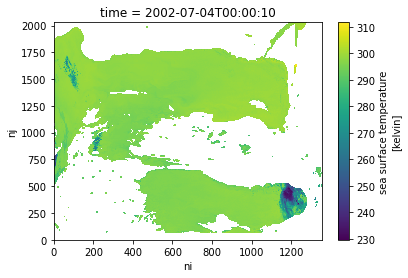

In [11]:
from pandas.plotting import register_matplotlib_converters

ds_MODIS.sea_surface_temperature.plot()

We can see the time this file represents, and the variable, but it's hard to tell where on the map we are. Let's try it another way:

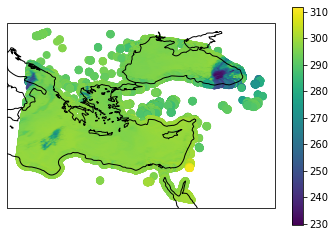

In [25]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

plt.scatter(ds_MODIS.lon, ds_MODIS.lat, lw=2, c=ds_MODIS.sea_surface_temperature)
plt.colorbar()
#plt.clim(-0.3, 0.3)

plt.show()

We can double check the data by plotting it in a separate application, such as Panoply. The data matches, in this case we're looking at MODIS SST over the Meditterranean Sea, at the first time stamp in the collection.

<img align="left"
     src="MODIS_SST_demo2.png">

## 3. Select data with shp file using the CMR API

Now that we've previewed the data and decided we'd like to request more, specific to our use case, we can pass the collection ID into the CMR API to *search* by geographic shape file. The service to *subset by shp* is also in development and should be available in 2021.

### Access data selected by geographic shapefile
We will request data overlapping the Gulf of Mexico by uploading a shape file with that boundary. This shape file can be one that you created, shred by a collaborator, or any other user, as long as it follows shape file convention. In essence, this following service allows the user to bring their own shape file to do a data search. The returned response will provide a list of data files from the cloud-based PO.DAAC archive (Earthdata Cloud) that intersect this given shape file.

This requires the use of a multipart/form-data POST request. Supported shapefile formats include ESRI, GeoJSON, and KML. The associated mime-types are as follows:

| Shapefile Format | mime-type |
|:-----------------|----------:|
| ESRI | application/shapefile+zip |
| GeoJSON | application/geo+json |
| KML | application/vnd.google-earth.kml+xml |

ESRI shapefiles must be uploaded as a single .zip file.

### Example with ESRI .shp file:

We will now search with an ESRI shapefile and a temporal bound to limit our space and time region of interest. Namely, we will search over the Gulf of Mexico during the period 1 Aug 2020 to 1 Nov 2020, since we are interested in exploring how SST responds during the latest Atlantic hurricane season. Our spatial boundary shape file to search with over the Gulf of Mexico looks like this (previewed in QGIS):

<img align="center"
     src="Gulf_Mexico_shp_QGIS_zoom.png">

**Lesson Note:** You are once again searching on data that lives in the PO.DAAC (Earthdata) cloud archive, from your local computer, by running this next code snippet. You are searching spatially (via shape file boundaries) and temporally.

(Side note: the token parameter below allows you to access this new PO.DAAC cloud operational archive space. This is possible because your Earthdata login was added to a list of early access users to this cloud environment, for this workshop.)

In [26]:
import requests
import json
import pprint

# the URL of the CMR searvice
url = 'https://cmr.earthdata.nasa.gov/search/granules.umm_json'

#The shapefile we want to use in our search
shp_file = open('resources/gulf_shapefile.zip', 'rb')

#need to declare the file and the type we are uploading
files = {'shapefile':('gulf_shapefile.zip',shp_file, 'application/shapefile+zip')}

#used to define parameters such as the concept-id and things like temporal searches
parameters = {'collection_concept_id':'C1940473819-POCLOUD', 'token': _token, 'temporal':'2020-08-01T00:00:00Z,2020-11-01T00:00:00Z'}

response = requests.post(url, files=files, params=parameters)
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(response.json())

{ 'hits': 279,
  'items': [ { 'meta': { 'concept-id': 'G1966393158-POCLOUD',
                         'concept-type': 'granule',
                         'format': 'application/vnd.nasa.cmr.umm+json',
                         'native-id': '20200801062501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0',
                         'provider-id': 'POCLOUD',
                         'revision-date': '2020-11-13T03:39:00.242Z',
                         'revision-id': 1},
               'umm': { 'CollectionReference': { 'ShortName': 'MODIS_A-JPL-L2P-v2019.0',
                                                 'Version': '2019.0'},
                        'DataGranule': { 'ArchiveAndDistributionInformation': [ { 'Checksum': { 'Algorithm': 'MD5',
                                                                                                'Value': 'ebca8db617da8c071eabb0b2cb4703ea'},
                                                                                  'Name': '20200801062501-JPL-L2P_

## 4. Preview the selected data

The `POCLOUD` in the response above signals that you are indeed searching on data from the PO.DAAC archive within the Earthdata Cloud.

Let's take a look at the url for the first data file this spatial and temporal search result returned:

In [27]:
new_modis_url = response.json()['items'][0]['umm']['RelatedUrls'][0]['URL']
new_modis_url

'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MODIS_A-JPL-L2P-v2019.0/20200801062501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc'

In [ ]:
# add code to download and preview

## 5. Download after spatial and temporal selection
Loop to download the MODIS SST files based on our search criteria (those that intersect the region of interest (defined by our shapefile here) and our period of interest.

### ??? How do we cleanly loop through the url's and download all retured ???

In [ ]:
# # code goes here
# r = requests.get(new_modis_url)
# with open('tutorial2_data_MODIS_from_shp.nc', 'wb') as f:
#     f.write(r.content)
# .
# .
# .
# ... 

**For now, let's plot the first files** from our query, that we have downloaded to your local space.

In [28]:
# code goes herer = requests.get(modis_url)
r = requests.get(new_modis_url)
with open('tutorial2_data_MODIS_from_shp.nc', 'wb') as f:
    f.write(r.content)

In [29]:
ds_MODIS_shp = xa.open_dataset('tutorial2_data_MODIS_from_shp.nc')
ds_MODIS_shp

<xarray.Dataset>
Dimensions:                      (ni: 1354, nj: 2030, time: 1)
Coordinates:
    lat                          (nj, ni) float32 ...
    lon                          (nj, ni) float32 ...
  * time                         (time) datetime64[ns] 2020-08-01T06:25:01
Dimensions without coordinates: ni, nj
Data variables:
    sea_surface_temperature      (time, nj, ni) float32 ...
    sst_dtime                    (time, nj, ni) timedelta64[ns] ...
    quality_level                (time, nj, ni) float32 ...
    sses_bias                    (time, nj, ni) float32 ...
    sses_standard_deviation      (time, nj, ni) float32 ...
    l2p_flags                    (time, nj, ni) int16 ...
    sea_surface_temperature_4um  (time, nj, ni) float32 ...
    quality_level_4um            (time, nj, ni) float32 ...
    sses_bias_4um                (time, nj, ni) float32 ...
    sses_standard_deviation_4um  (time, nj, ni) float32 ...
    wind_speed                   (time, nj, ni) float32 ...
    dt_analysis                  (time, nj, ni) float32 ...
Attributes:
    Conventions:                CF-1.7, ACDD-1.3
    title:                      MODIS Aqua L2P SST
    summary:                    Sea surface temperature retrievals produced a...
    references:                 GHRSST Data Processing Specification v2r5
    institution:                NASA/JPL/OBPG/RSMAS
    history:                    MODIS L2P created at JPL PO.DAAC
    comment:                    L2P Core without DT analysis or other ancilla...
    license:                    GHRSST and PO.DAAC protocol allow data use as...
    id:                         MODIS_A-JPL-L2P-v2019.0
    naming_authority:           org.ghrsst
    product_version:            2019.0
    uuid:                       f6e1f61d-c4a4-4c17-8354-0c15e12d688b
    gds_version_id:             2.0
    netcdf_version_id:          4.1
    date_created:               20201104T080319Z
    file_quality_level:         3
    spatial_resolution:         1km
    start_time:                 20200801T062501Z
    time_coverage_start:        20200801T062501Z
    stop_time:                  20200801T062958Z
    time_coverage_end:          20200801T062958Z
    northernmost_latitude:      22.6651
    southernmost_latitude:      1.76101
    easternmost_longitude:      -58.1812
    westernmost_longitude:      -83.4502
    source:                     MODIS sea surface temperature observations fo...
    platform:                   Aqua
    sensor:                     MODIS
    metadata_link:              http://podaac.jpl.nasa.gov/ws/metadata/datase...
    keywords:                   Oceans > Ocean Temperature > Sea Surface Temp...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.01
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.01
    acknowledgment:             The MODIS L2P sea surface temperature data ar...
    creator_name:               Ed Armstrong, JPL PO.DAAC
    creator_email:              edward.m.armstrong@jpl.nasa.gov
    creator_url:                http://podaac.jpl.nasa.gov
    project:                    Group for High Resolution Sea Surface Tempera...
    publisher_name:             The GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L2P
    cdm_data_type:              swath
    startDirection:             Descending
    endDirection:               Descending
    day_night_flag:             Night

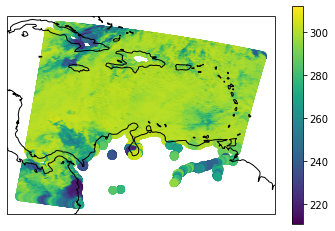

In [30]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

plt.scatter(ds_MODIS_shp.lon, ds_MODIS_shp.lat, lw=2, c=ds_MODIS_shp.sea_surface_temperature)
plt.colorbar()
#plt.clim(-0.3, 0.3)

plt.show()

This file intersects our shp boundary. In this case, just barely, but it does. We can confirm our search by doing the same query in the **Earthdata Search** portal mentioned at the beginning of the tutorial. 

https://search.earthdata.nasa.gov/search/granules?p=C1940473819-POCLOUD&pg[0][gsk]=-start_date&q=POCLOUD%20MODIS&polygon[0]=-83.77698%2C30.19984%2C-92.50277%2C29.56938%2C-97.13009%2C27.5373%2C-97.92334%2C23.11736%2C-96.20462%2C19.29736%2C-91.04847%2C19.23496%2C-89.32976%2C21.09642%2C-84.63634%2C21.40447%2C-80.93449%2C24.92861%2C-83.77698%2C30.19984&m=17.033007339234686!-100.458984375!4!1!0!0%2C2&qt=2020-08-01T00%3A00%3A00.000Z%2C2020-11-01T23%3A59%3A59.999Z&sf=4876504323&sfs[0]=0&tl=1590373340!4!!

Indeed the granule returned matches the search boundary: 

<img align="center"
     src="EDS_shp_granule.png">